# NOTEBOOK TO COMPUTE TOPIC MODELING ON THE EXTRACTED TWEETS

In [1]:
#NB: You need to install pytorch 
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
#!pip install sentence-transformers
#!pip install umap
#!pip install umap-learn
#!pip install hdbscan
#!pip install umap-learn
#!pip install -U feel-it



# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import umap.umap_ as umap
from sentence_transformers import SentenceTransformer
import hdbscan
from wordcloud import WordCloud



/tmp/ipykernel_22770/2092763840.py:13: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/home/wtto/Documents/Computational_Modeling/CompModVenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data

df = pd.read_csv('cleaned_data.csv')

df

,tweet
0,"Il “governo ammucchiata”, tutti insieme con PD..."
1,".@VittorioSgarbi: ""Verrà un tempo in cui Conte..."
2,🇮🇹🇮🇹🇮🇹 https://t.co/OO047uCKTN
3,"Un commosso addio a Roberto Brivio, artista in..."
4,Fiducia in questo Parlamento? NO Fiducia negli...
...,...
46419,Al mercato di via Ettore Ponti http://yfrog....
46420,Sl mercato di via de Guarnieri Milano...
46421,al mercato di via Osoppo a Milano. Se volete r...
46422,www.immaginami.it


In [3]:
data = list(df['tweet'])

## CREATE EMBEDDING REPRESENTATIONS /LOAD THEM IF YOU ALREADY HAVE THE FILE FROM THE REPO

In [4]:
"""model = SentenceTransformer('distilbert-multilingual-nli-stsb-quora-ranking')
#embeddings = model.encode(data, show_progress_bar=True) # you need to run this the first time, then you can load the embeddings from the file because we will save them in the next cell"""

# Save the embeddings 

#np.save('embeddings.npy', embeddings) # save the embeddings

# Load the embeddings

embeddings = np.load('embeddings.npy') # load the embeddings

# INITIALIZE RANDOM SEED FOR REPRODUCIBILITY

In [5]:
random_seed = 42

# UMAP - DIMENSIONALITY REDUCTION

In [6]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine',
                            random_state=random_seed).fit_transform(embeddings)

/home/wtto/Documents/Computational_Modeling/CompModVenv/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


HDBSCAN - CLUSTERING

In [7]:
cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

# DATA VISUALIZATION

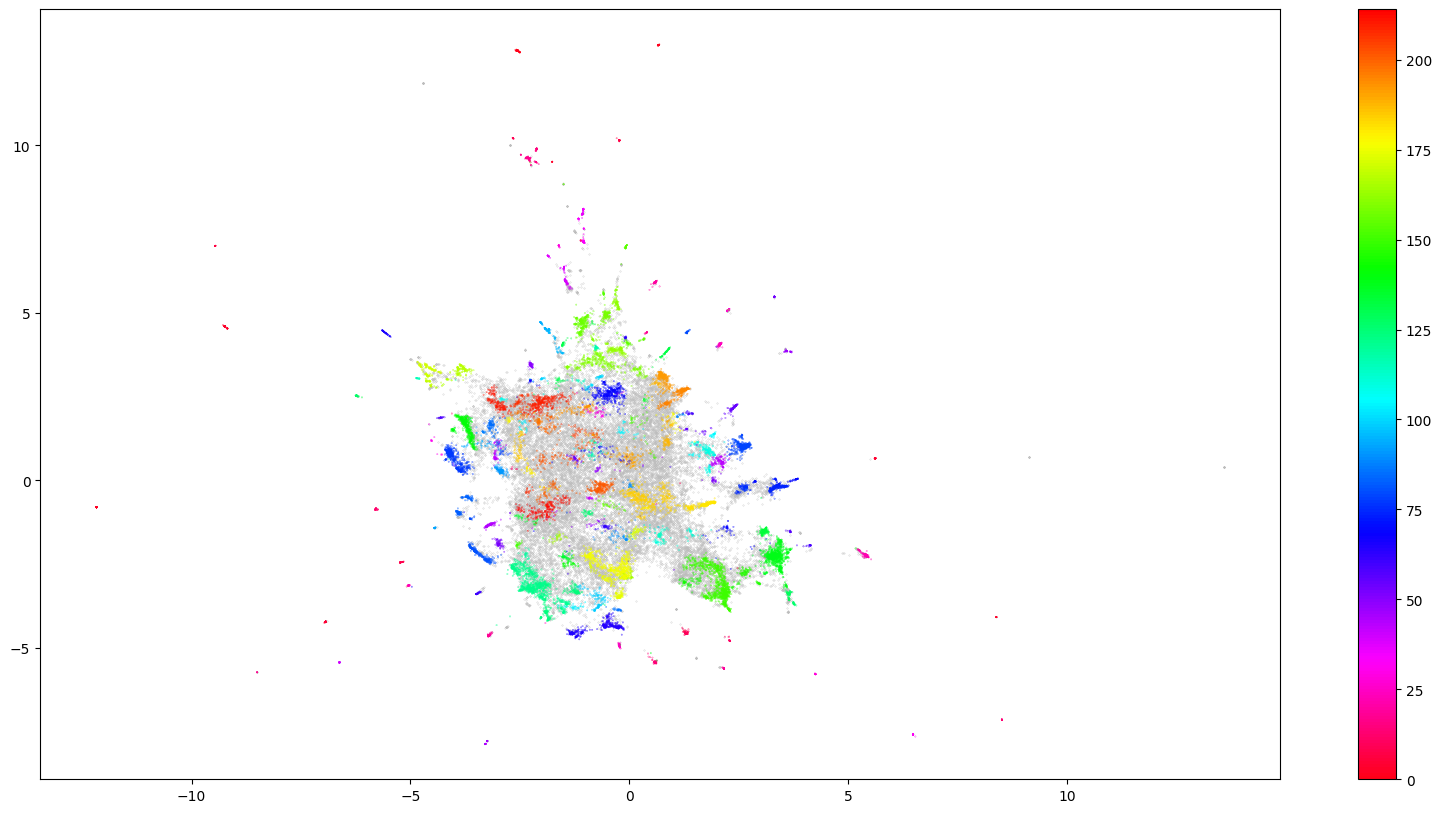

In [8]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

# CREATE TOPICS USING C-TF-IDF (CLASS BASED TF-IDF)

In [9]:
#create df

docs_df = pd.DataFrame(data, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))

#merging the documents with the same topic
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [10]:
# c_tf_idf function::
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words= "english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
# Compute tf_idf
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

# INTERPRET THE TOPICS

In [11]:
# Extract top n words per topic
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names_out()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words



# Extract topic sizes
def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic']).Doc.count().reset_index().rename({"Topic": "Topic", "Doc": "Size"}, axis='columns').sort_values("Size", ascending=False))
    return topic_sizes

# Get top words and topic sizes
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df)

In [12]:
# LET’S LOOK AT THE 20 MOST FREQUENT TOPICS
topic_sizes.head(21)

,Topic,Size
0,-1,28366
151,150,907
139,138,861
123,122,816
177,176,552
78,77,508
70,69,484
185,184,470
80,79,435
142,141,423


# Code to Extract and Create a Dataframe of the 21 Most Frequent Topics

This code extracts the top 5 representative words for the 21 most frequent topics from the topic modeling results and creates a dataframe with columns for "Topic", "Size", and "Representative Words".

In [13]:
most_frequent_topics = topic_sizes.head(21)

# Create a list to store data for the new dataframe
data = []

# Loop through the most frequent topics to get the representative words
for index, row in most_frequent_topics.iterrows():
    topic = row['Topic']
    size = row['Size']
    # Get the top 5 words for this topic
    top_words = top_n_words[topic][:5]
    # Concatenate the words with underscores
    representative_words = "_".join([word for word, _ in top_words])
    # Append the data to the list
    data.append([topic, size, representative_words])

# Create a new dataframe with the desired columns
df_topics = pd.DataFrame(data, columns=["Topic", "Size", "Representative Words"])



df_topics.to_csv("top_21_topics.csv", index=False)

# Display the dataframe
df_topics


,Topic,Size,Representative Words
0,-1,28366,che_la_il_non_salvini
1,150,907,tasse_pagare_le_fiscale_tax
2,138,861,europa_euro_salvini_europea_ue
3,122,816,immigrazione_immigrati_profughi_clandestina_sono
4,176,552,galera_carcere_detenuti_delinquenti_penitenziaria
5,77,508,roma_piazza_com_pic_twitter
6,69,484,pic_twitter_olio_latte_com
7,184,470,governo_salvini_non_il_che
8,79,435,scuola_insegnanti_scuole_azzolina_studenti
9,141,423,milano_milan_com_facebook_twitter


## Topics 122 (third most frequent) is about immigrants and immigration in general, topic 64 (the 13th most frequent) is about islam and terrorism and muslims, topic 81 (the 15th) is about immigrants landing in sicily and topic 123 (20th) is about NGOs and immigrants/immigration. We will extract the tweets from these topics and analyse them as being immigration-related tweets.

# PLOT THE 20 MOST FREQUENT TOPICS

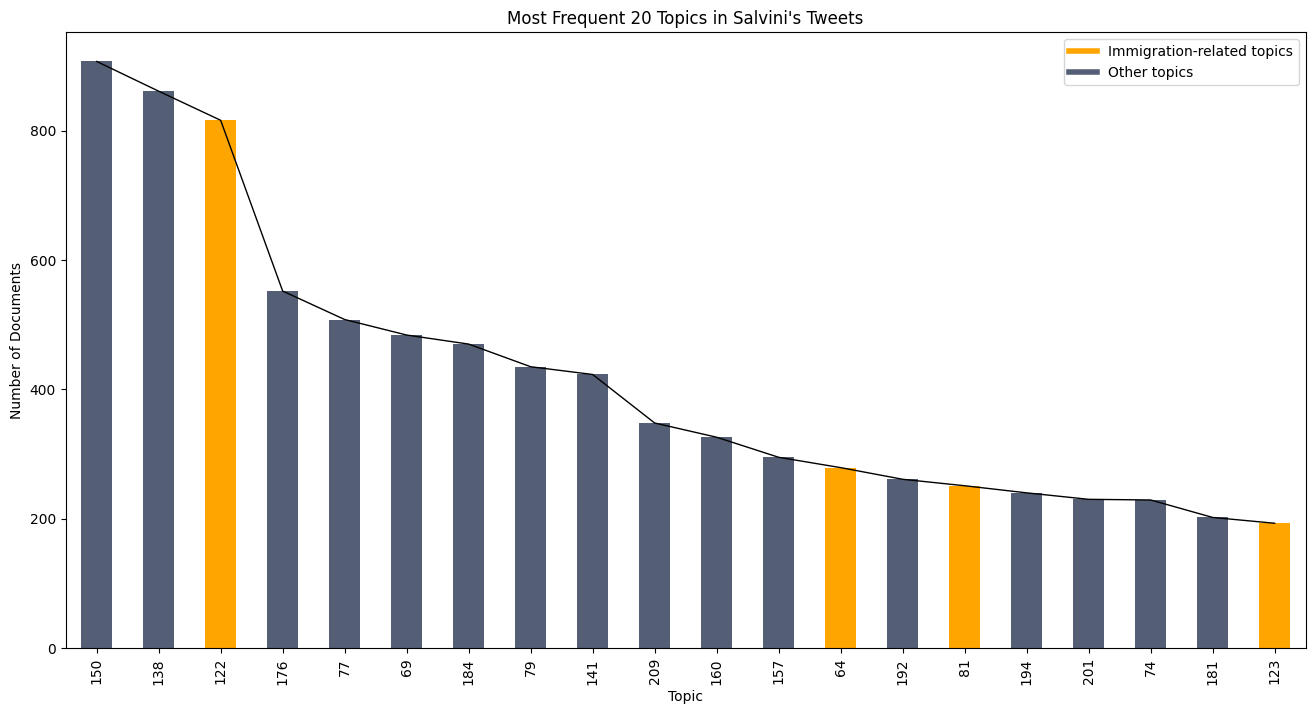

In [14]:
# Filter out the first topic (-1)
filtered_topic_sizes = topic_sizes[topic_sizes['Topic'] != -1]

# Define colors for specific topics
colors = ['#545E75' if topic not in [122, 64, 81, 123] else 'orange' for topic in filtered_topic_sizes['Topic']]

# Plot
fig, ax = plt.subplots(figsize=(16, 8))
bars = filtered_topic_sizes.head(20).plot(kind='bar', x='Topic', y='Size', ax=ax, color=colors, legend=False)

# Collect the x and y coordinates of the top of each bar
x_coords = [bar.get_x() + bar.get_width() / 2 for bar in bars.patches]
y_coords = [bar.get_height() for bar in bars.patches]

# Add a line connecting the tops of the bars
ax.plot(x_coords, y_coords, 'k-', linewidth=1)

# Add a legend
custom_lines = [plt.Line2D([0], [0], color='orange', lw=4),
                plt.Line2D([0], [0], color='#545E75', lw=4)]
ax.legend(custom_lines, ['Immigration-related topics', 'Other topics'])

ax.set_ylabel('Number of Documents')
ax.set_title('Most Frequent 20 Topics in Salvini\'s Tweets')

plt.show()
              

In [15]:
#save the plot an image for latex
fig.savefig('topics.png') #save the plot as an image


# LET’S CREATE WORDCLOUD REPRESENTATIONS OF TOPICS 122-64-81-123 HWICH ARE THE IMMIGRATION-RELATED TOPICS IN THE 20 MOST FREQUENT TOPICS

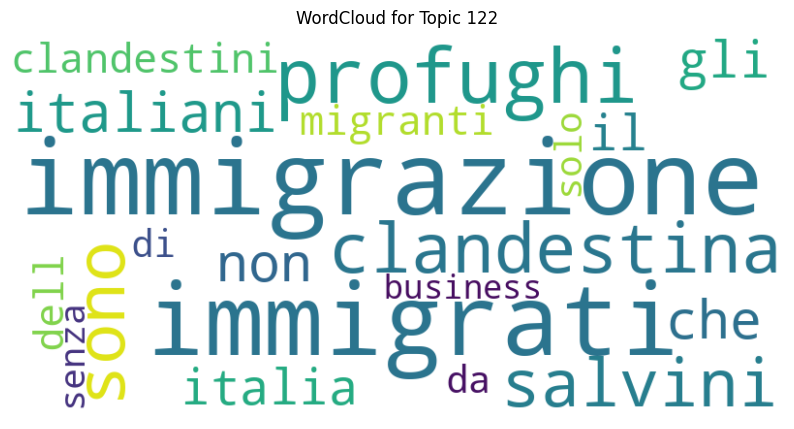

In [16]:
top_n_words_122 = top_n_words[122]  # Replace 122 with your actual topic number

# Extract words and their TF-IDF scores
words_122 = [word for word, _ in top_n_words_122]
tfidf_scores_122 = [score for _, score in top_n_words_122]

# Create a dictionary of words with TF-IDF scores
word_dict_122 = {word: score for word, score in zip(words_122, tfidf_scores_122)}

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict_122)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Topic 122')
plt.savefig('wordcloud_topic_122.png', dpi=300, bbox_inches='tight')
plt.show()


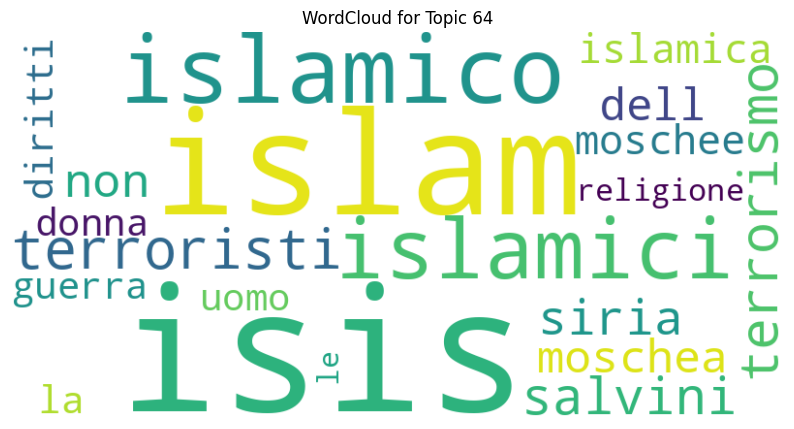

In [17]:
top_n_words_64 = top_n_words[64]  # Replace 64 with your actual topic number

# Extract words and their TF-IDF scores
words_64 = [word for word, _ in top_n_words_64]
tfidf_scores_64 = [score for _, score in top_n_words_64]

# Create a dictionary of words with TF-IDF scores
word_dict_64 = {word: score for word, score in zip(words_64, tfidf_scores_64)}

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict_64)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Topic 64')
plt.savefig('wordcloud_topic_64.png', dpi=300, bbox_inches='tight')
plt.show()

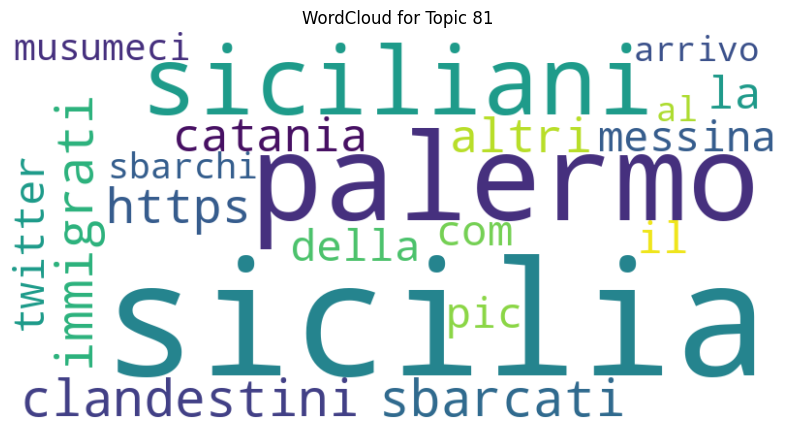

In [18]:
top_n_words_81 = top_n_words[81]  # Replace 81 with your actual topic number

# Extract words and their TF-IDF scores
words_81 = [word for word, _ in top_n_words_81]
tfidf_scores_81 = [score for _, score in top_n_words_81]

# Create a dictionary of words with TF-IDF scores
word_dict_81 = {word: score for word, score in zip(words_81, tfidf_scores_81)}

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict_81)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Topic 81')
plt.savefig('wordcloud_topic_81.png', dpi=300, bbox_inches='tight')
plt.show()

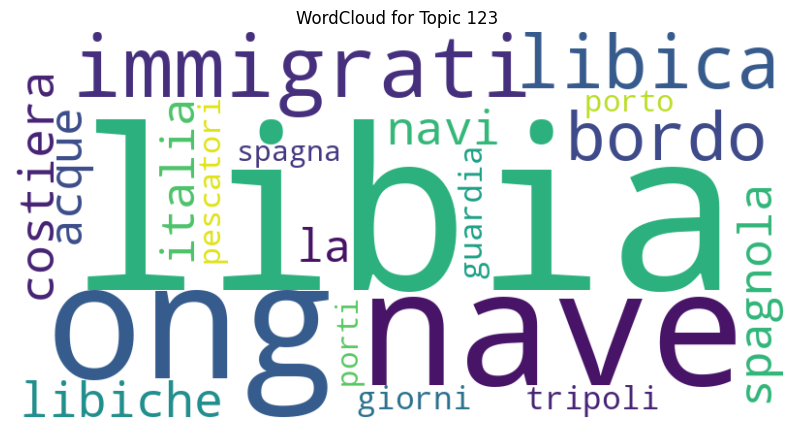

In [19]:
top_n_words_123 = top_n_words[123]  # Replace 123 with your actual topic number

# Extract words and their TF-IDF scores
words_123 = [word for word, _ in top_n_words_123]
tfidf_scores_123 = [score for _, score in top_n_words_123]

# Create a dictionary of words with TF-IDF scores
word_dict_123 = {word: score for word, score in zip(words_123, tfidf_scores_123)}

# Generate the WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_dict_123)

# Plot the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud for Topic 123')
plt.savefig('wordcloud_topic_123.png', dpi=300, bbox_inches='tight')
plt.show()

# Ok so important topics for us are 122 (3rd most frequent topic - immigrati, immigrazione, profughi), il 64 (13esimo topic - isis, islam, terroristi), 81 (15esimo - sicilia, clandestini, sbarchi), 123 (20esimo - ONG, nave, immigrati)

In [20]:
# Extract all the tweets in a topic

def extract_topic_tweets(df, topic_id):
    topic_tweets = df[df['Topic'] == topic_id]
    return topic_tweets


In [21]:
#tweets in topic 122

topic_122 = extract_topic_tweets(docs_df, 122)  # here docs_df is the dataframe containing all the tweets and their topics

topic_122

file_name = '_'.join([word[0] for word in top_n_words[122][:5]]) + '.csv'
topic_122.to_csv(file_name, index=False)

In [22]:
topic_64 = extract_topic_tweets(docs_df, 64)  # here docs_df is the dataframe containing all the tweets and their topics

topic_64

file_name = '_'.join([word[0] for word in top_n_words[64][:5]]) + '.csv'
topic_64.to_csv(file_name, index=False)

In [23]:
topic_81 = extract_topic_tweets(docs_df, 81)  # here docs_df is the dataframe containing all the tweets and their topics

topic_81

file_name = '_'.join([word[0] for word in top_n_words[81][:5]]) + '.csv'
topic_81.to_csv(file_name, index=False)

In [25]:
topic_123 = extract_topic_tweets(docs_df, 123)  # here docs_df is the dataframe containing all the tweets and their topics  

topic_123

file_name = '_'.join([word[0] for word in top_n_words[123][:5]]) + '.csv'
topic_123.to_csv(file_name, index=False)

In [26]:
# file with all the tweets for all the 4 topics (122, 64, 81, 123)

all_topics = pd.concat([topic_122, topic_64, topic_81, topic_123])

all_topics

all_topics.to_csv('all_topics.csv', index=False)

In [27]:
len(topic_122) + len(topic_64) + len(topic_81) + len(topic_123)

1539